In [98]:
#imporitng necessary intial packages
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from collections import Counter
from imblearn.over_sampling import SMOTE,ADASYN
from imblearn.combine import SMOTEENN
from sklearn.svm import SVC

**• DOMAIN:** Banking, Marketing

<br>**• CONTEXT:** A bank X is on a massive digital transformation for all its departments. Bank has a growing customer base whee majority of them are
liability customers (depositors) vs borrowers (asset customers). The bank is interested in expanding the borrowers base rapidly to bring in more
business via loan interests. A campaign that the bank ran in last quarter showed an average single digit conversion rate. Digital transformation
being the core strength of the business strategy, marketing department wants to devise effective campaigns with better target marketing to
increase the conversion ratio to double digit with same budget as per last campaign.

<br>**• DATA DICTIONARY:** 
<br>**1.** ID: Customer ID
<br>**2.** Age: Customer’s approximate age.
<br>**3.** CustomerSince: Customer of the bank since. [unit is masked]
<br>**4.** HighestSpend: Customer’s highest spend so far in one transaction. [unit is masked]
<br>**5.** ZipCode: Customer’s zip code.
<br>**6.** HiddenScore: A score associated to the customer which is masked by the bank as an IP.
<br>**7.** MonthlyAverageSpend: Customer’s monthly average spend so far. [unit is masked]
<br>**8.** Level: A level associated to the customer which is masked by the bank as an IP.
<br>**9.** Mortgage: Customer’s mortgage. [unit is masked]
<br>**10.** Security: Customer’s security asset with the bank. [unit is masked]
<br>**11.** FixedDepositAccount: Customer’s fixed deposit account with the bank. [unit is masked]
<br>**12.** InternetBanking: if the customer uses internet banking.
<br>**13.** CreditCard: if the customer uses bank’s credit card.
<br>**14.** LoanOnCard: if the customer has a loan on credit card.

<br>**• PROJECT OBJECTIVE:** Build a Machine Learning model to perform focused marketing by predicting the potential customers who will convert
using the historical dataset.

<br>**• STEPS AND TASK:**

**1. Data Understanding and Preparation**

**A. Read both the Datasets ‘Data1’ and ‘Data 2’ as DataFrame and store them into two separate variables**

In [242]:
df_1 = pd.read_csv("Part2-Data1.csv")
df_2 = pd.read_csv("Part2-Data2.csv")

**B. Print shape and Column Names and DataTypes of both the Dataframes.**

In [243]:
df_namelist = ['df_1', 'df_2']
df_list = [df_1, df_2]
for i in range(0,len(df_list)):
    print(df_namelist[i])
    print('Shape - ', df_list[i].shape[0], 'rows', df_list[i].shape[1], 'columns \n')
    print('Column Names - ', df_list[i].columns.to_list(), '\n\nDtypes')
    print(df_list[i].dtypes)
    print('\n***************************************** \n')

df_1
Shape -  5000 rows 8 columns 

Column Names -  ['ID', 'Age', 'CustomerSince', 'HighestSpend', 'ZipCode', 'HiddenScore', 'MonthlyAverageSpend', 'Level'] 

Dtypes
ID                       int64
Age                      int64
CustomerSince            int64
HighestSpend             int64
ZipCode                  int64
HiddenScore              int64
MonthlyAverageSpend    float64
Level                    int64
dtype: object

***************************************** 

df_2
Shape -  5000 rows 7 columns 

Column Names -  ['ID', 'Mortgage', 'Security', 'FixedDepositAccount', 'InternetBanking', 'CreditCard', 'LoanOnCard'] 

Dtypes
ID                       int64
Mortgage                 int64
Security                 int64
FixedDepositAccount      int64
InternetBanking          int64
CreditCard               int64
LoanOnCard             float64
dtype: object

***************************************** 



**C. Merge both the Dataframes on ‘ID’ feature to form a single DataFrame**

In [244]:
df = pd.merge(df_1,df_2, how='inner', left_on='ID', right_on='ID')
df.shape

(5000, 14)

**D. Change Datatype of below features to ‘Object’**

‘CreditCard’, ‘InternetBanking’, ‘FixedDepositAccount’, ‘Security’, ‘Level’, ‘HiddenScore’.

In [245]:
col_list = ['CreditCard','InternetBanking','FixedDepositAccount','Security','Level','HiddenScore']
for i in range(0, len(col_list)):
    df[col_list[i]] = df[col_list[i]].astype(object, errors='ignore')
df.dtypes

ID                       int64
Age                      int64
CustomerSince            int64
HighestSpend             int64
ZipCode                  int64
HiddenScore             object
MonthlyAverageSpend    float64
Level                   object
Mortgage                 int64
Security                object
FixedDepositAccount     object
InternetBanking         object
CreditCard              object
LoanOnCard             float64
dtype: object

**2. Data Exploration and Analysis:**

**A. Visualize distribution of Target variable ‘LoanOnCard’ and clearly share insights.**

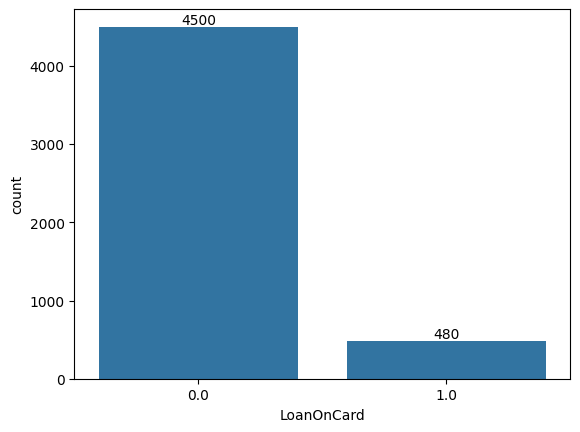

In [246]:
ax = sns.countplot(data=df,x='LoanOnCard',stat='count');
ax.bar_label(ax.containers[0]);

Taking "0" as "Loan Declined" and "1" as "Laon given",
<br>This shows that the bank doesn't offer loan that easily on cards and that's why only ~10% of the total application gets approved to get the loan.
Also, there are 20 null values, that either needs to be removed or taken care of in later stage.

**B. Check the percentage of missing values and impute if required.**

In [247]:
(df.isnull().sum()/df.shape[0])

ID                     0.000
Age                    0.000
CustomerSince          0.000
HighestSpend           0.000
ZipCode                0.000
HiddenScore            0.000
MonthlyAverageSpend    0.000
Level                  0.000
Mortgage               0.000
Security               0.000
FixedDepositAccount    0.000
InternetBanking        0.000
CreditCard             0.000
LoanOnCard             0.004
dtype: float64

We only have null values in our target variable "LoanOnCard". It only has 0.4% of the total i.e. 20 rows out of 5000 as null. Therefore because of such a low number we can drop the null records.

In [248]:
df.dropna(inplace=True)

**C. Check for unexpected values in each categorical variable and impute with best suitable value.**

[Unexpected values means if all values in a feature are 0/1 then ‘?’, ‘a’, 1.5 are unexpected values which needs treatment ]

In [249]:
col_obj = df.iloc[:,1:14].columns
for i in range(0,len(col_obj)):
    print(df[col_obj[i]].value_counts(),'\n**********************************\n')

Age
43    149
35    148
52    145
54    143
58    143
50    136
30    136
56    135
41    135
34    134
57    132
39    132
59    132
51    129
45    126
46    126
42    126
60    126
55    125
31    125
40    124
29    123
62    123
61    122
44    121
32    120
33    119
48    117
49    115
38    115
47    112
53    111
63    108
36    107
37    105
28    103
27     90
65     79
26     78
64     78
25     51
24     28
66     24
67     12
23     12
Name: count, dtype: int64 
**********************************

CustomerSince
 32    154
 20    148
 5     146
 9     145
 23    144
 35    143
 25    142
 28    138
 18    137
 19    134
 26    133
 24    130
 3     129
 14    127
 30    126
 34    125
 16    125
 17    125
 27    124
 29    124
 22    121
 7     121
 6     119
 8     118
 15    118
 33    117
 10    117
 37    116
 13    116
 11    116
 4     113
 36    113
 21    113
 31    104
 12    102
 38     88
 39     85
 2      84
 1      73
 0      66
 40     57
 41     42
-1     

So we don't have any typos or unexpected value in our feature columns other than 'CustomerSince'. It has some negative values which doesn't make sense

In [250]:
df[df['CustomerSince']<0]['CustomerSince'].value_counts()

CustomerSince
-1    32
-2    15
-3     4
Name: count, dtype: int64

As we cannot further analyze what it means in absense of SME of the business, we will mark these as typos and will remove the negative sign

In [251]:
df['CustomerSince'] = df['CustomerSince'].apply(lambda x: x*-1 if x<0 else x)

**3. Data Preparation and model building:**

**A. Split data into X and Y.**

[Recommended to drop ID & ZipCode. LoanOnCard is target Variable]

**Answer**

dropping unwanted columns like ID and ZipCode. THough location can be one of the important metric, we are drippoing ZipCode because it is numeric in nature, so it won't help us inprediction and can also harm the accuracy. To make it useful we will need to turn that zipcode into city name and the do "One hot encoding" to make it useful. For our project we will proceed without it and will come back if we want to increase the accurancy

In [255]:
df.drop(['ID','ZipCode'], axis=1, inplace=True)

#spliting into x,y
x=df.drop(['LoanOnCard'], axis=1)
y= df['LoanOnCard']

**B. Split data into train and test. Keep 25% data reserved for testing.**

In [256]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)

**C. Train a Supervised Learning Classification base model - Logistic Regression.**

In [257]:
#creating model
model = LogisticRegression(solver="liblinear")
#training the model on train data
model.fit(x_train, y_train)

#predicting test data using trained model
y_predict = model.predict(x_test)


**D. Print evaluation metrics for the model and clearly share insights.**

Score of the model 0.95


<Axes: >

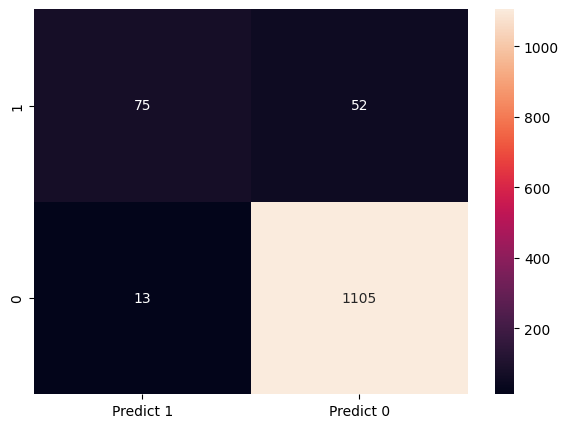

In [258]:
model_score = model.score(x_test, y_test)
print('Score of the model %.2f' %model_score)

cm=metrics.confusion_matrix(y_test, y_predict, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True, fmt='.0f')

In [259]:
print(classification_report(y_test, y_predict))
print("ROC AUC Score %.2f" %roc_auc_score(y_test, y_predict, average='weighted'))

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97      1118
         1.0       0.85      0.59      0.70       127

    accuracy                           0.95      1245
   macro avg       0.90      0.79      0.83      1245
weighted avg       0.94      0.95      0.94      1245

ROC AUC Score 0.79


In [263]:
accuracy = accuracy_score(y_test, y_predict)
error_rate = 1 - accuracy
precision = precision_score(y_test, y_predict, average='weighted')
recall = recall_score(y_test, y_predict, average='weighted') 
f1 = f1_score(y_test, y_predict, average='weighted')

The confusion matrix

True Positives (TP): we correctly predicted that they should get loan **75**

True Negatives (TN): we correctly predicted that they shouldn't get loan **1105**

False Positives (FP): we incorrectly predicted that they hould get loan (a "Type I error") **13** Falsely predict positive Type I error

False Negatives (FN): we incorrectly predicted that they shouldn't get loan (a "Type II error") **52** Falsely predict negative Type II error


<br>We have a model score of 95%, which is really a good score.
<br>Precision of the model for people who should get a loan is 96% compared to 85% who should get the loan. Thought the accuracy of finding the right person to give loan is less but Bank always want to know whether it is safe to give loan or not, which our model will do fine.
<br> Same goes with recall, as it give 99% score to tell Bank that they shoudl not offer a loan to a person x.
<br>F1-score for rejecting an application is 97%, which again says our model is good.
<br>ROC AUC score is 79% which is on a lower side.

**E. Balance the data using the right balancing technique.**
<br>i. Check distribution of the target variable
<br>ii. Say output is class A : 20% and class B : 80%
<br>iii. Here you need to balance the target variable as 50:50.
<br>iv. Try appropriate method to achieve the same.

In [264]:
y_train.value_counts()/y_train.shape[0]

LoanOnCard
0.0    0.905489
1.0    0.094511
Name: count, dtype: float64

The distribution of our target variable is ~90:10, therfore ~90% as "0" and ~10% as "1"
<br> We will use SMOTE technique in order to balance the data

* **Random Over Sampling (ROS):** This simply duplicates data points from the minority class randomly. It's a quick and easy approach, but it can lead to overfitting because the model memorizes the duplicated data.
* **SMOTE (Synthetic Minority Over-sampling Technique):** This technique creates synthetic data points for the minority class by interpolating between existing minority class data points. It can be more effective than ROS but requires more computational resources.

In [265]:
# Count class labels
class_counts = Counter(y_train)
minority_class = class_counts.most_common()[-1][0]  #last class is the minority i.e. "1"

# Create the SMOTE object (adjust k_neighbors as needed to improve)
#smote = SMOTE(k_neighbors=5)
smote = SMOTE()

# Oversample the minority class
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)


print("Original Class Counts:", class_counts)
print("Resampled Class Counts:", Counter(y_train_resampled))







# # Count class labels
# class_counts = Counter(y_train)
# minority_class = class_counts.most_common()[-1][0]  #last class is the minority i.e. "1"

# # Create the SMOTE object (adjust k_neighbors as needed to improve)
# #smote = SMOTE(k_neighbors=5)
# smote = ADASYN(random_state=130)

# # Oversample the minority class
# x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)


# print("Original Class Counts:", class_counts)
# print("Resampled Class Counts:", Counter(y_train_resampled))









# # Count class labels
# class_counts = Counter(y_train)
# minority_class = class_counts.most_common()[-1][0]  #last class is the minority i.e. "1"

# # Create the SMOTE object (adjust k_neighbors as needed to improve)
# #smote = SMOTE(k_neighbors=5)
# smote = SMOTEENN(random_state=130)

# # Oversample the minority class
# x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)


# print("Original Class Counts:", class_counts)
# print("Resampled Class Counts:", Counter(y_train_resampled))

Original Class Counts: Counter({0.0: 3382, 1.0: 353})
Resampled Class Counts: Counter({0.0: 3382, 1.0: 3382})


I did oversappling with SOMTE, ADASYN and SMOTEENN. Out of which SMOTE was performing better than any other.

**F. Again train the same previous model on balanced data.**

In [266]:
#creating model
model = LogisticRegression(solver="liblinear")
#training the model on train data
model.fit(x_train_resampled, y_train_resampled)

#predicting test data using trained model
y_predict = model.predict(x_test)


**G. Print evaluation metrics and clearly share differences observed.**

Score of the model 0.89


<Axes: >

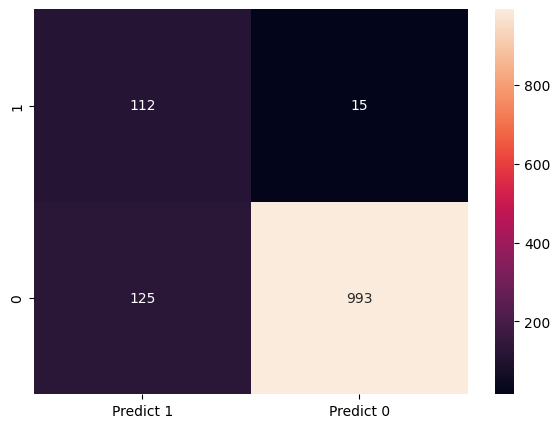

In [267]:
model_score = model.score(x_test, y_test)
print('Score of the model %.2f' %model_score)

cm=metrics.confusion_matrix(y_test, y_predict, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True, fmt='.0f')

In [268]:
print(classification_report(y_test, y_predict))
print("ROC AUC Score %.2f" %roc_auc_score(y_test, y_predict, average='weighted'))

              precision    recall  f1-score   support

         0.0       0.99      0.89      0.93      1118
         1.0       0.47      0.88      0.62       127

    accuracy                           0.89      1245
   macro avg       0.73      0.89      0.77      1245
weighted avg       0.93      0.89      0.90      1245

ROC AUC Score 0.89


In [269]:
accuracy_2 = accuracy_score(y_test, y_predict)
error_rate_2 = 1 - accuracy_2
precision_2 = precision_score(y_test, y_predict, average='weighted')
recall_2 = recall_score(y_test, y_predict, average='weighted') 
f1_2 = f1_score(y_test, y_predict, average='weighted')

In [270]:
print("Accurancy decreased by %.2f" %(((accuracy_2-accuracy)/accuracy)*100),'%')
print("Precision decreased by %.2f" %(((precision_2-precision)/precision)*100),'%')
print("Error rate increased by %.2f" %(((error_rate_2-error_rate)/error_rate)*100),'%')
print("Recall decreased by %.2f" %(((recall_2-recall)/recall)*100),'%')
print("F1 Score decreased by %.2f" %(((f1_2-f1)/f1)*100),'%')

Accurancy decreased by -6.36 %
Precision decreased by -1.24 %
Error rate increased by 115.38 %
Recall decreased by -6.36 %
F1 Score decreased by -4.44 %


Balancing the train data hasn't helped us any but has made our model poorer overall.
<br> Precision for telling not to give has increased from 94% to 99% which is a good thing but at the same time Recall and F1 score for not giving loan to a person has fallen down.
<br>ROC AUC score improved from 79% to 89%
<br>False Positives (FP): we incorrectly predicted that they hould get loan (a "Type I error") **125** Falsely predict positive Type I error, which definitely what we don't want.

**4. Performance Improvement:**

**A. Train a base model each for SVM, KNN**

SVM

Score of the model 0.90
              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95      1118
         1.0       0.65      0.10      0.18       127

    accuracy                           0.90      1245
   macro avg       0.78      0.55      0.56      1245
weighted avg       0.88      0.90      0.87      1245



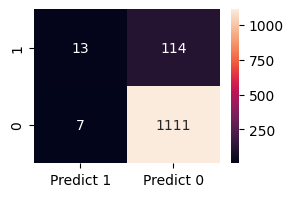

In [271]:
#defininf the SVM model
Model1=SVC()
#training the model
Model1.fit(x_train,y_train)
#predicitng y_test
y_predict1=Model1.predict(x_test)

model_score = Model1.score(x_test, y_test)
print('Score of the model %.2f' %model_score)
print(classification_report(y_test, y_predict1))


accuracy = accuracy_score(y_test, y_predict1)
error_rate = 1 - accuracy
precision = precision_score(y_test, y_predict1, average='weighted')
recall = recall_score(y_test, y_predict1, average='weighted') 
f1 = f1_score(y_test, y_predict1, average='weighted')

cm=metrics.confusion_matrix(y_test, y_predict1, labels=[1, 0])
df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]], columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (3,2))
sns.heatmap(df_cm, annot=True, fmt='.0f')
plt.show()

KNN

Score of the model 0.90
              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95      1118
         1.0       0.65      0.10      0.18       127

    accuracy                           0.90      1245
   macro avg       0.78      0.55      0.56      1245
weighted avg       0.88      0.90      0.87      1245



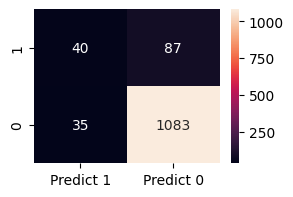

In [272]:
#defininf the KNN model
Model2 = KNeighborsClassifier()
#training the model
Model2.fit(x_train, y_train)
#predicitng y_test
y_predict2=Model2.predict(x_test)

model_score = Model2.score(x_test, y_test)
print('Score of the model %.2f' %model_score)
print(classification_report(y_test, y_predict1))

cm=metrics.confusion_matrix(y_test, y_predict2, labels=[1, 0])
df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]], columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (3,2))
sns.heatmap(df_cm, annot=True, fmt='.0f')
plt.show()

**B. Tune parameters for each of the models wherever required and finalize a model.**

(Optional: Experiment with various Hyperparameters - Research required)

**Tuning KNN with different parameters**

In [103]:
result_train = {}
result_test = {}

#This function concatenate test and train scores in a dataframe
def prepare_dataframe(test_score_dict,train_score_dict,key,columns):
    df_test = pd.DataFrame(test_score_dict,index = ["Test Score"])
    df_train = pd.DataFrame(train_score_dict,index = ["Train Score"])
    np_result = np.concatenate([df_test,df_train],axis = 0)
    df_result = pd.DataFrame(np_result)

    df_result.index = ["Test Score","Train Score"]
    df_result.columns = [key + str(c) for c in columns]  
    return df_result

#Implementing KNN algoritms with different parameters
def knn_model(n_neighbors = 5,weights = 'uniform',algorithm = 'auto',p = 2):
    knn = KNeighborsClassifier(n_neighbors = n_neighbors,
                               weights = weights,
                               algorithm = algorithm,
                               p = p
                              )
    
    accuracies_train = cross_val_score(estimator = knn, X = x_train, y = y_train, cv = 3)
    train_score = np.mean(accuracies_train)
    
    knn.fit(x_train,y_train)
    test_score = knn.score(x_test,y_test)
   
    return train_score, test_score

In [104]:
#KNN algorithm implementation with default parameters
train_score,test_score = knn_model()
result_train["Default-Train"] = train_score
result_test["Default-Test"] = test_score
print("Mean accuracy of train set:",train_score)
print("Mean accuracy of test set:", test_score) 

Mean accuracy of train set: 0.9046854082998661
Mean accuracy of test set: 0.9020080321285141


**n_neighbors**

In [105]:
#KNN algorith implementation with different n_neighbors 
k_list = list(np.arange(1,285))
test_score_dict = {}
train_score_dict = {}

for k in k_list:
    train_score,test_score = knn_model(n_neighbors = k)
    train_score_dict[k] = (train_score)
    test_score_dict[k] = (test_score)
    
df_result = prepare_dataframe(test_score_dict,train_score_dict,"K = ",k_list)
df_result

,K = 1,K = 2,K = 3,K = 4,K = 5,K = 6,K = 7,K = 8,K = 9,K = 10,...,K = 275,K = 276,K = 277,K = 278,K = 279,K = 280,K = 281,K = 282,K = 283,K = 284
Test Score,0.900402,0.909237,0.897992,0.898795,0.902008,0.902008,0.904418,0.900402,0.903614,0.902811,...,0.897992,0.897992,0.897992,0.897992,0.897992,0.897992,0.897992,0.897992,0.897992,0.897992
Train Score,0.906560,0.915663,0.912985,0.912718,0.904685,0.909505,0.906560,0.912182,0.911111,0.910308,...,0.905489,0.905489,0.905489,0.905489,0.905489,0.905489,0.905489,0.905489,0.905489,0.905489


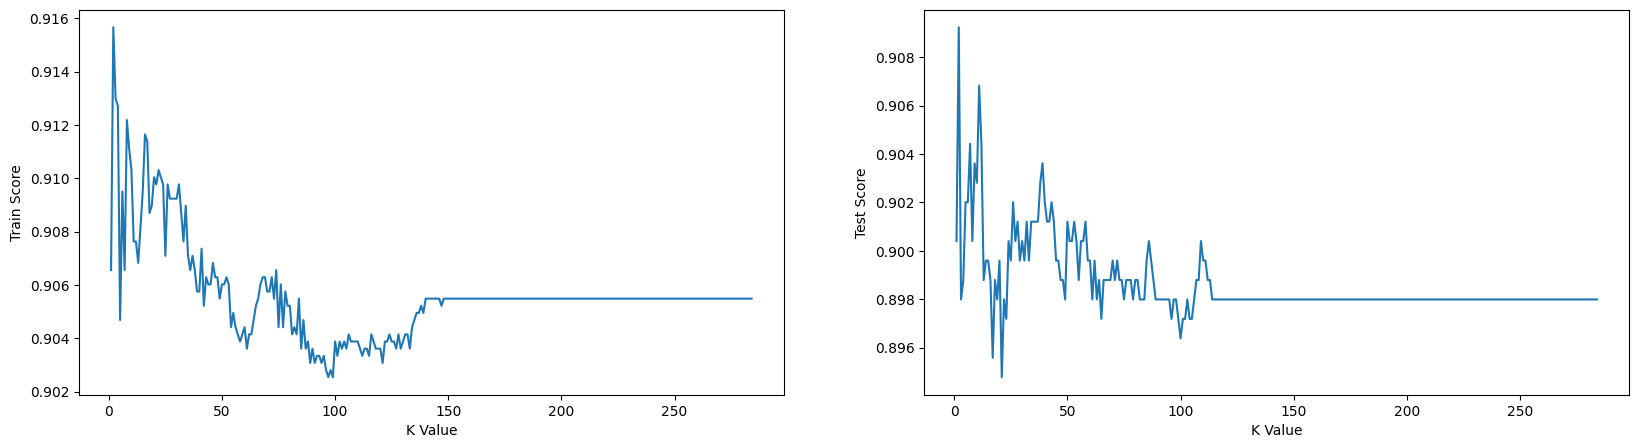

In [106]:
#Plot score of different k values for test and train datas
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.plot(k_list,list(train_score_dict.values()))
plt.xlabel("K Value")
plt.ylabel("Train Score")

plt.subplot(1,2,2)
plt.plot(k_list,list(test_score_dict.values()))
plt.xlabel("K Value")
plt.ylabel("Test Score")
plt.show()

In [107]:
#Results stored in dictionaries
result_train["K-Best-Train"] = np.asarray(list(train_score_dict.values())).max()
result_test["K-Best-Test"] = np.asarray(list(test_score_dict.values())).max()

**weights**

In [108]:
#KNN algorith implementation with different weights 
w_list = ['uniform','distance']

test_score_dict = {}
train_score_dict = {}

for w in w_list:
    train_score,test_score = knn_model(weights = w)
    train_score_dict[w] = (train_score)
    test_score_dict[w] = (test_score)

prepare_dataframe(test_score_dict,train_score_dict,"Weight = ",w_list)

,Weight = uniform,Weight = distance
Test Score,0.902008,0.901205
Train Score,0.904685,0.910308


In [109]:
#Results stored in dictionaries
result_train["Weight-Best-Train"] = np.asarray(list(train_score_dict.values())).max()
result_test["Weight-Best-Test"] = np.asarray(list(test_score_dict.values())).max()

**algorithm**

In [111]:
#KNN algorith implementation with different algorithm
a_list = ['auto','ball_tree','kd_tree','brute']

test_score_dict = {}
train_score_dict = {}

for a in a_list:
    train_score,test_score = knn_model(algorithm = a)
    train_score_dict[a] = (train_score)
    test_score_dict[a] = (test_score)

prepare_dataframe(test_score_dict,train_score_dict,"Algorithm = ",a_list)

,Algorithm = auto,Algorithm = ball_tree,Algorithm = kd_tree,Algorithm = brute
Test Score,0.902008,0.902008,0.902008,0.902008
Train Score,0.904685,0.904685,0.904685,0.904685


In [112]:
#Results stored in dictionaries
result_train["Algorithm-Best-Train"] = np.asarray(list(train_score_dict.values())).max()
result_test["Algorithm-Best-Test"] = np.asarray(list(test_score_dict.values())).max()

**p-value**

<br>If p = 1, this is equivalent to using manhattan_distance(l_1)
<br>
If p = 2, this is equivalent to using euclidean_distance(l_2)<br>
If p > 2, It is minkowski distance(l_p).

In [113]:
#KNN algorith implementation with different p
p_list = list(np.arange(1,11))


test_score_dict = {}
train_score_dict = {}

for p in p_list:
    train_score,test_score = knn_model(p = p)
    train_score_dict[p] = (train_score)
    test_score_dict[p] = (test_score)

prepare_dataframe(test_score_dict,train_score_dict,"P = ",p_list)

,P = 1,P = 2,P = 3,P = 4,P = 5,P = 6,P = 7,P = 8,P = 9,P = 10
Test Score,0.914859,0.902008,0.888353,0.887550,0.889960,0.889960,0.889157,0.88996,0.889157,0.889157
Train Score,0.922088,0.904685,0.901205,0.900669,0.900134,0.899598,0.898795,0.89826,0.897992,0.897456


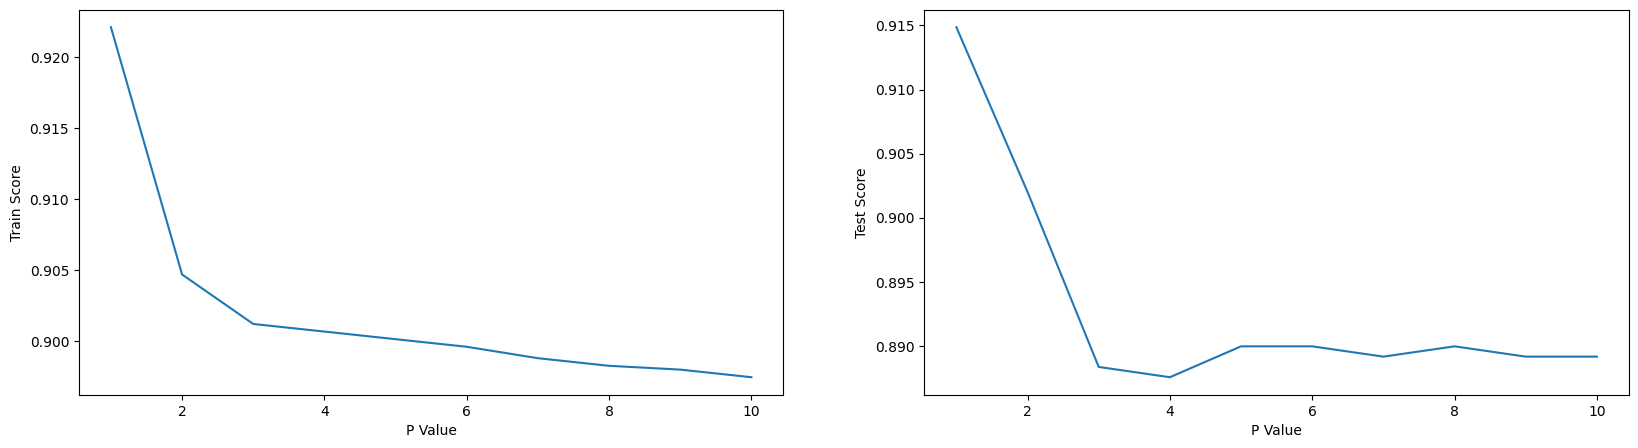

In [114]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.plot(p_list,list(train_score_dict.values()))
plt.xlabel("P Value")
plt.ylabel("Train Score")

plt.subplot(1,2,2)
plt.plot(p_list,list(test_score_dict.values()))
plt.xlabel("P Value")
plt.ylabel("Test Score")
plt.show()

In [115]:
#Results stored in dictionaries
result_train["P-Best-Train"] = np.asarray(list(train_score_dict.values())).max()
result_test["P-Best-Test"] = np.asarray(list(test_score_dict.values())).max()

**GridSearch**

In [117]:
#Implementation of GridSearch
grid = {'n_neighbors':np.arange(1,235),
        'p':np.arange(1,3),
        'weights':['uniform','distance'],
        'algorithm':['auto','ball_tree','kd_tree','brute']
       }
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn,grid,cv=3)
knn_cv.fit(x_train,y_train)

print("Hyperparameters:",knn_cv.best_params_)
print("Train Score:",knn_cv.best_score_)
result_train["GridSearch-Best-Train"] = knn_cv.best_score_

Hyperparameters: {'algorithm': 'auto', 'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Train Score: 0.9285140562248996


In [120]:
#Results stored in dictionaries
result_test["GridSearch-Best-Test"] = knn_cv.score(x_test,y_test)
print("Test Score:",knn_cv.score(x_test,y_test))

Test Score: 0.9180722891566265


**Conclusion**

In [121]:
#Result dataframe
columns = ["Default","K-Best","Weight-Best","Algorithm-Best","P-Best","GridSearchCV"]
prepare_dataframe(result_test,result_train,"",columns)

,Default,K-Best,Weight-Best,Algorithm-Best,P-Best,GridSearchCV
Test Score,0.902008,0.909237,0.902008,0.902008,0.914859,0.918072
Train Score,0.904685,0.915663,0.910308,0.904685,0.922088,0.928514


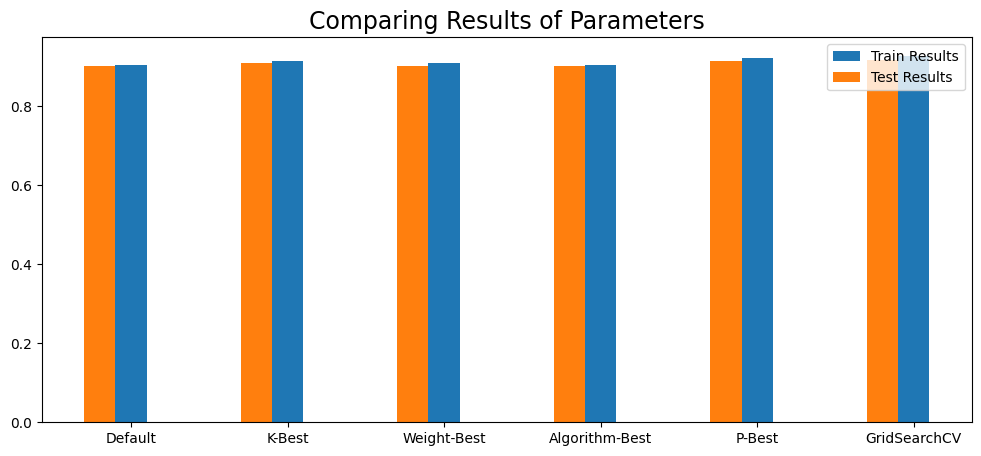

In [125]:
#Bar plot for showing result of parameters both train and test datas
plt.figure(figsize = (12,5))
X = np.arange(len(result_train))
ax = plt.subplot(111)
ax.bar(X, result_train.values(), width=0.2,  align='center')
ax.bar(X-0.2, result_test.values(), width=0.2,  align='center')
ax.legend(('Train Results','Test Results'))
plt.xticks(X, columns)
plt.title("Comparing Results of Parameters", fontsize=17)
plt.show()

We were able to boost the model score to ~92% on test data with GridSerachCV hyperparamter tuning for KNN. And so far that's the best score we have.

**Tuning SVM**

**With default parameter**

In [126]:
svc = SVC()
accuracies = cross_val_score(estimator=svc, X = x_train, y = y_train, cv = 3)
train_score = np.mean(accuracies)
    
svc.fit(x_train,y_train)
test_score = svc.score(x_test,y_test)

print("Train Score of Default Parameters:",train_score)
print("Test Score of Default Parameters:",test_score)

Train Score of Default Parameters: 0.9078982597054885
Test Score of Default Parameters: 0.9028112449799197


**Tuning SVM with different parameters**

**Regularization Parameter (C)**

We can say that the goal of the SVM algorithn is low misclassification and large margin. But this two goals are contradictory. Actually, C parameter can be used to provides the balance between these goals.

<br>-If we choose large value for C, we get small margin but lower misclassification
<br>-If we choose small value for C, we get large margin but high misclassification compared to large C value.

When training an SVM with the Radial Basis Function (RBF) kernel, two parameters must be considered: C and gamma. The parameter C, common to all SVM kernels, trades off misclassification of training examples against simplicity of the decision surface. A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected.

In [138]:
#Hyperparamter tuning using Gridsearch
svm = SVC()
# param_grid = {'C':[0.01,0.05,0.1,1,10, 100, 1000],'kernel':['linear','rbf'], 'gamma':['scale','auto'] }
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','linear']}
grid = GridSearchCV(svm,param_grid)

#Fitting the model
grid.fit(x_train,y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear']})

In [139]:
#Calculating the accuracy of tuned model
grid_svc = grid.predict(x_test)
accuracy_score(y_test,grid_svc)

0.9654618473895582

In [140]:
#Classification report for the tuned model
print(classification_report(y_test,grid_svc))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      1118
         1.0       0.91      0.73      0.81       127

    accuracy                           0.97      1245
   macro avg       0.94      0.86      0.90      1245
weighted avg       0.96      0.97      0.96      1245



In [141]:
print(grid.best_params_)
print(grid.best_estimator_.get_params())

{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
{'C': 1000, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.0001, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


**C. Print evaluation metrics for final model.**

Score of the best SVM model 0.97
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      1118
         1.0       0.91      0.73      0.81       127

    accuracy                           0.97      1245
   macro avg       0.94      0.86      0.90      1245
weighted avg       0.96      0.97      0.96      1245



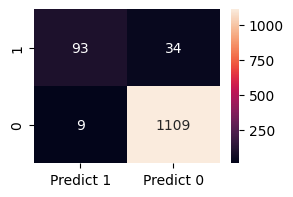

*************************************************



Score of the best KNN model 0.92
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      1118
         1.0       0.91      0.73      0.81       127

    accuracy                           0.97      1245
   macro avg       0.94      0.86      0.90      1245
weighted avg       0.96      0.97      0.96      1245



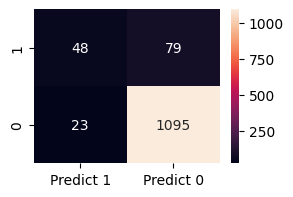

*************************************************





In [157]:
#best model SVM
#Hyperparameters: {'algorithm': 'auto', 'n_neighbors': 4, 'p': 1, 'weights': 'distance'}

best_svm = SVC(kernel="rbf",gamma=0.0001,C=1000)
best_svm.fit(x_train,y_train)
#predicitng y_test
y_predict1 = best_svm.predict(x_test)
model_score = best_svm.score(x_test, y_test)
print('Score of the best SVM model %.2f' %model_score)
print(classification_report(y_test, y_predict1))

cm=metrics.confusion_matrix(y_test, y_predict1, labels=[1, 0])
df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]], columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (3,2))
sns.heatmap(df_cm, annot=True, fmt='.0f')
plt.show()

print('*************************************************\n\n\n')










#best model KNN
best_knn = KNeighborsClassifier(algorithm='auto', n_neighbors= 4, p=1, weights='distance')
#training the model
best_knn.fit(x_train, y_train)
#predicitng y_test
y_predict2=best_knn.predict(x_test)

model_score = best_knn.score(x_test, y_test)
print('Score of the best KNN model %.2f' %model_score)
print(classification_report(y_test, y_predict1))

cm=metrics.confusion_matrix(y_test, y_predict2, labels=[1, 0])
df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]], columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (3,2))
sns.heatmap(df_cm, annot=True, fmt='.0f')
plt.show()

print('*************************************************\n\n\n')


Clearly the SVM model outperforms the KNN model and therefore we will be moving with SVM as our final model

**D. Share improvement achieved from base model to final model.**

In [158]:
accuracy_2 = accuracy_score(y_test, y_predict1)
error_rate_2 = 1 - accuracy_2
precision_2 = precision_score(y_test, y_predict1, average='weighted')
recall_2 = recall_score(y_test, y_predict1, average='weighted') 
f1_2 = f1_score(y_test, y_predict1, average='weighted')

**Defalt SVM Model**

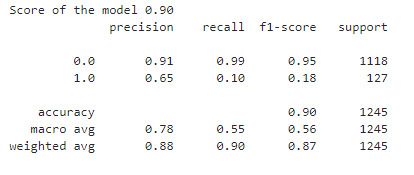

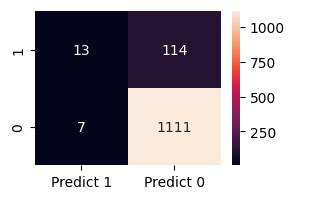

**Final/Best SVM Model**

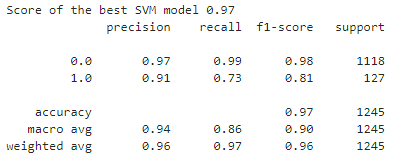

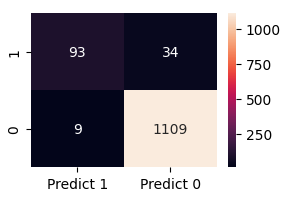

*********************************************************************

In [161]:
print("Accurancy increased by %.2f" %(((accuracy_2-accuracy)/accuracy)*100),'%')
print("Precision increased by %.2f" %(((precision_2-precision)/precision)*100),'%')
print("Error rate decreased by %.2f" %(((error_rate_2-error_rate)/error_rate)*100),'%')
print("Recall increased by %.2f" %(((recall_2-recall)/recall)*100),'%')
print("F1 Score increased by %.2f" %(((f1_2-f1)/f1)*100),'%')

Accurancy increased by 6.94 %
Precision increased by 9.49 %
Error rate decreased by -64.46 %
Recall increased by 6.94 %
F1 Score increased by 10.82 %


So clearly our with all positive metrics getting increased as well as getting the predition rate better looking at the Type1 and Type2 error, we can say that our model has performed really well than the base one.